In [1]:
# %pip install -qq -U diffusers transformers ftfy pyarrow==9.0.0
%cd ..
%load_ext autoreload
%autoreload 2

/home/smehta/Projects/OverFlow


In [2]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [3]:
from src.hparams import create_hparams
from src.utilities.data import TextMelLoader, TextMelMotionCollate
from torch.utils.data import DataLoader

In [4]:
hparams = create_hparams()

In [5]:
trainset = TextMelLoader(
            hparams.training_files, hparams, [hparams.mel_normaliser], [hparams.motion_normaliser]
)

train_dataloader = DataLoader(
            trainset,
            batch_size=12,
            collate_fn=TextMelMotionCollate(hparams.n_frames_per_step),
            num_workers=hparams.num_workers,
            pin_memory=True,
        )

Data cache found at : data/filelists/cormac_train.txt.cleaned! Loading cache...


  0%|          | 0/4812 [00:00<?, ?it/s]

Done caching mels! New mels cached: 0


In [6]:
from diffusers import DDIMScheduler, DDPMScheduler
from src.model.diffusion import GradLogPEstimator2d
from src.model.wavegrad import WaveGrad

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from src.utilities.functions import fix_len_compatibility, get_mask_from_len
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt

In [8]:
noise_scheduler = DDIMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

net = GradLogPEstimator2d(
    64,
    n_feats=80,
    n_spks=1
).to(device)

losses = []


net = WaveGrad(
    motion_in_channels=80, 
    latent_in_channels=80
).to(device)


opt = torch.optim.Adam(net.parameters(), lr=1e-3)


In [9]:
loss_fn = nn.L1Loss()

# The optimizer

# Keeping a record of the losses for later viewing

# The training loop
for epoch in range(5):
    pbar = tqdm(train_dataloader)
    pbar.set_description(f'Epoch: {epoch}')
    for batch in pbar:
        text_padded, input_lengths, mel_padded, motion_padded, output_lengths = batch
        # Get some data and prepare the corrupted version
        
        
        x = mel_padded.to(device) 
        output_lengths = output_lengths.to(device)
        # output_lengths_max = fix_len_compatibility(int(output_lengths.max()))
        output_lengths_mask = get_mask_from_len(output_lengths, output_lengths.max(), device=x.device, dtype=x.dtype).unsqueeze(1)
        # original_length = x.shape[-1]
        # x = F.pad(x, (0, output_lengths_max - x.shape[-1]))
        
  
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
        
        # Get the model prediction
        pred = net(noisy_x, output_lengths_mask, noisy_x, timesteps) 

        # Calculate the loss
        loss = loss_fn(pred * output_lengths_mask, noise * output_lengths_mask) # How close is the output to the noise
        
        pbar.set_postfix({"loss" : loss.item()})

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

# View the loss curve

  0%|          | 0/401 [00:02<?, ?it/s]

Finished epoch 0. Average of the last 100 loss values: 0.237833


  0%|          | 0/401 [00:03<?, ?it/s]

Finished epoch 1. Average of the last 100 loss values: 0.214451


  0%|          | 0/401 [00:05<?, ?it/s]

Finished epoch 2. Average of the last 100 loss values: 0.198547


  0%|          | 0/401 [00:11<?, ?it/s]

Finished epoch 3. Average of the last 100 loss values: 0.193336


  0%|          | 0/401 [00:06<?, ?it/s]

Finished epoch 4. Average of the last 100 loss values: 0.190349


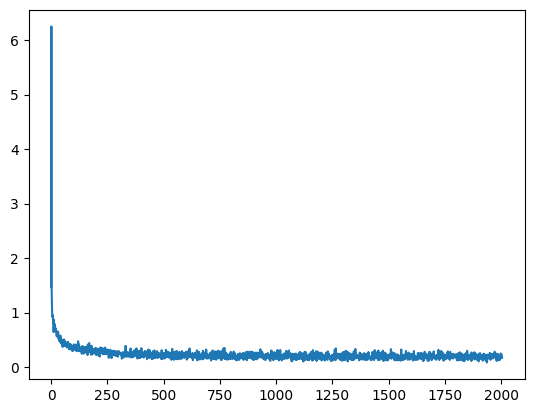

In [10]:
plt.plot(losses)

In [17]:
## DDPM
len_ = 1000
x = torch.randn(1, 80, len_).to(device)
mask = get_mask_from_len(torch.tensor([len_], device=device, dtype=torch.long), len_, device=x.device, dtype=x.dtype).unsqueeze(1)
noise_scheduler.set_timesteps(num_inference_steps=len_)
# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    
    x = scheduler.scale_model_input(x, t)
    # Get model pred
    t = t.unsqueeze(0).to(device)
    with torch.no_grad():
        residual = net(x, mask, x, t)  # Again, note that we pass in our labels y

    # Update sample with step
    x = noise_scheduler.step(residual, t, x, temperature=0.334).prev_sample

0it [00:00, ?it/s]

In [14]:
### DDIM
len_ = 1000
x = torch.randn(1, 80, len_).to(device)
mask = get_mask_from_len(torch.tensor([len_], device=device, dtype=torch.long), len_, device=x.device, dtype=x.dtype).unsqueeze(1)
noise_scheduler.set_timesteps(num_inference_steps=40)
# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    
    x = noise_scheduler.scale_model_input(x, t)
    # Get model pred
    t = t.unsqueeze(0).to(device)
    with torch.no_grad():
        residual = net(x, mask, x, t)  # Again, note that we pass in our labels y

    # Update sample with step
    x = noise_scheduler.step(residual, t, x, temperature=0.334).prev_sample * mask

0it [00:00, ?it/s]

In [15]:
mel_spectrogram = x.squeeze(0).cpu().detach().numpy()


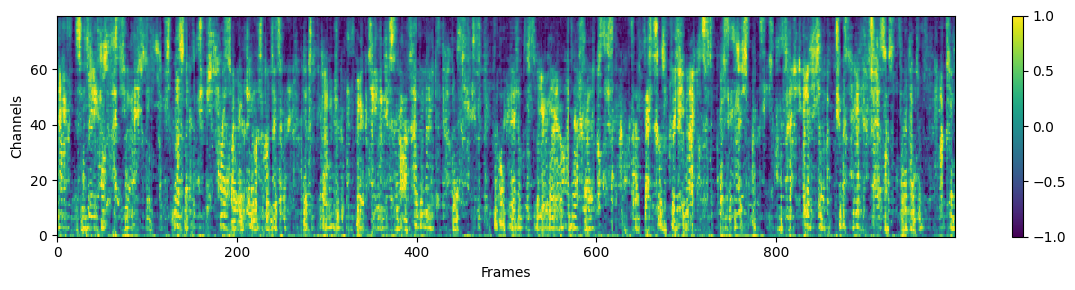

In [16]:
fig, ax = plt.subplots(figsize=(12, 3))
im = ax.imshow(mel_spectrogram, aspect="auto", origin="lower", interpolation="none")
plt.colorbar(im, ax=ax)
plt.xlabel("Frames")
plt.ylabel("Channels")
plt.tight_layout()
plt.show()